### Deploy a model
Let's load our sklearn-flavored model first:

In [9]:
%store -r best_traditional_model
%store -r features

I'd like to deploy it to AWS SageMaker. I was considering other options, as I know a lot of them since I myself worked in MLOps startup, but afterall it's better to go for one of the most mainstream approaches.
AWS has a special ML service, called SageMaker and one of the thing it can do is host a deployed model.
All we need is aws account and aws cli:

In [6]:
!aws --version

aws-cli/2.2.11 Python/3.8.8 Linux/5.4.0-131-generic exe/x86_64.ubuntu.20 prompt/off


To use sklearn model with SageMaker we need to wrap it with joblib library. It's an extra step, but we don't really need to change anything about the model itself.

In [18]:

import pandas as pd
import numpy as np
import joblib


with open('model.joblib', 'wb') as f:
    joblib.dump(best_traditional_model,f)


with open('model.joblib', 'rb') as f:
    predictor = joblib.load(f)

print("Testing following input: ")

predictor.predict(features.head(5))

Testing following input: 


array([ True, False,  True,  True, False])

OK, seems there's no problem with joblib. Let's now save that model to pre-created S3 bucket as a tar archive, as that's where SageMaker will load it from:

In [32]:
# !tar -czf model.tar.gz model.joblib
!tar -cvpzf model.tar.gz model.joblib entry_point.py
!aws s3 cp model.tar.gz s3://scikit-learn-sage-maker-model/model.tar.gz

model.joblib
entry_point.py
upload: ./model.tar.gz to s3://scikit-learn-sage-maker-model/model.tar.gz


Now, most interesting part. There are multiple programmatic ways to interact with SageMaker. A conventional option is to use general AWS client for Python(Boto3), but it's very verbose.
Check [boto3-based example](https://towardsdatascience.com/deploying-a-pre-trained-sklearn-model-on-amazon-sagemaker-826a2b5ac0b6).

What I find more appealing is to use SageMaker SDK for Python. It allows to avoid a lot of boilerplate.
I used [official docs](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#working-with-existing-model-data-and-training-jobs) for reference.

What's even cooler is that we will use a feature that's still in preview - we will deploy our model to serverless environment. Meaning we don't have a permanent server and only spin it up when the model endpoint is actually called.

In [ ]:
!pip install sagemaker

In [35]:
from sagemaker.sklearn.model import SKLearnModel

sklearn_model = SKLearnModel(model_data="s3://scikit-learn-sage-maker-model/model.tar.gz",
                             role="arn:aws:iam::076438626459:role/sage-maker-role",
                             entry_point="entry_point.py",
                             # framework_version="1.1.2",
                             framework_version="1.0-1"
                            )

from sagemaker.serverless import ServerlessInferenceConfig

# Specify MemorySizeInMB and MaxConcurrency in the serverless config object
serverless_config = ServerlessInferenceConfig(
  memory_size_in_mb=2048,
  max_concurrency=5,
)

serverless_predictor = sklearn_model.deploy(serverless_inference_config=serverless_config)

-----!

This is how model endpoint looks in AWS SageMaker console:

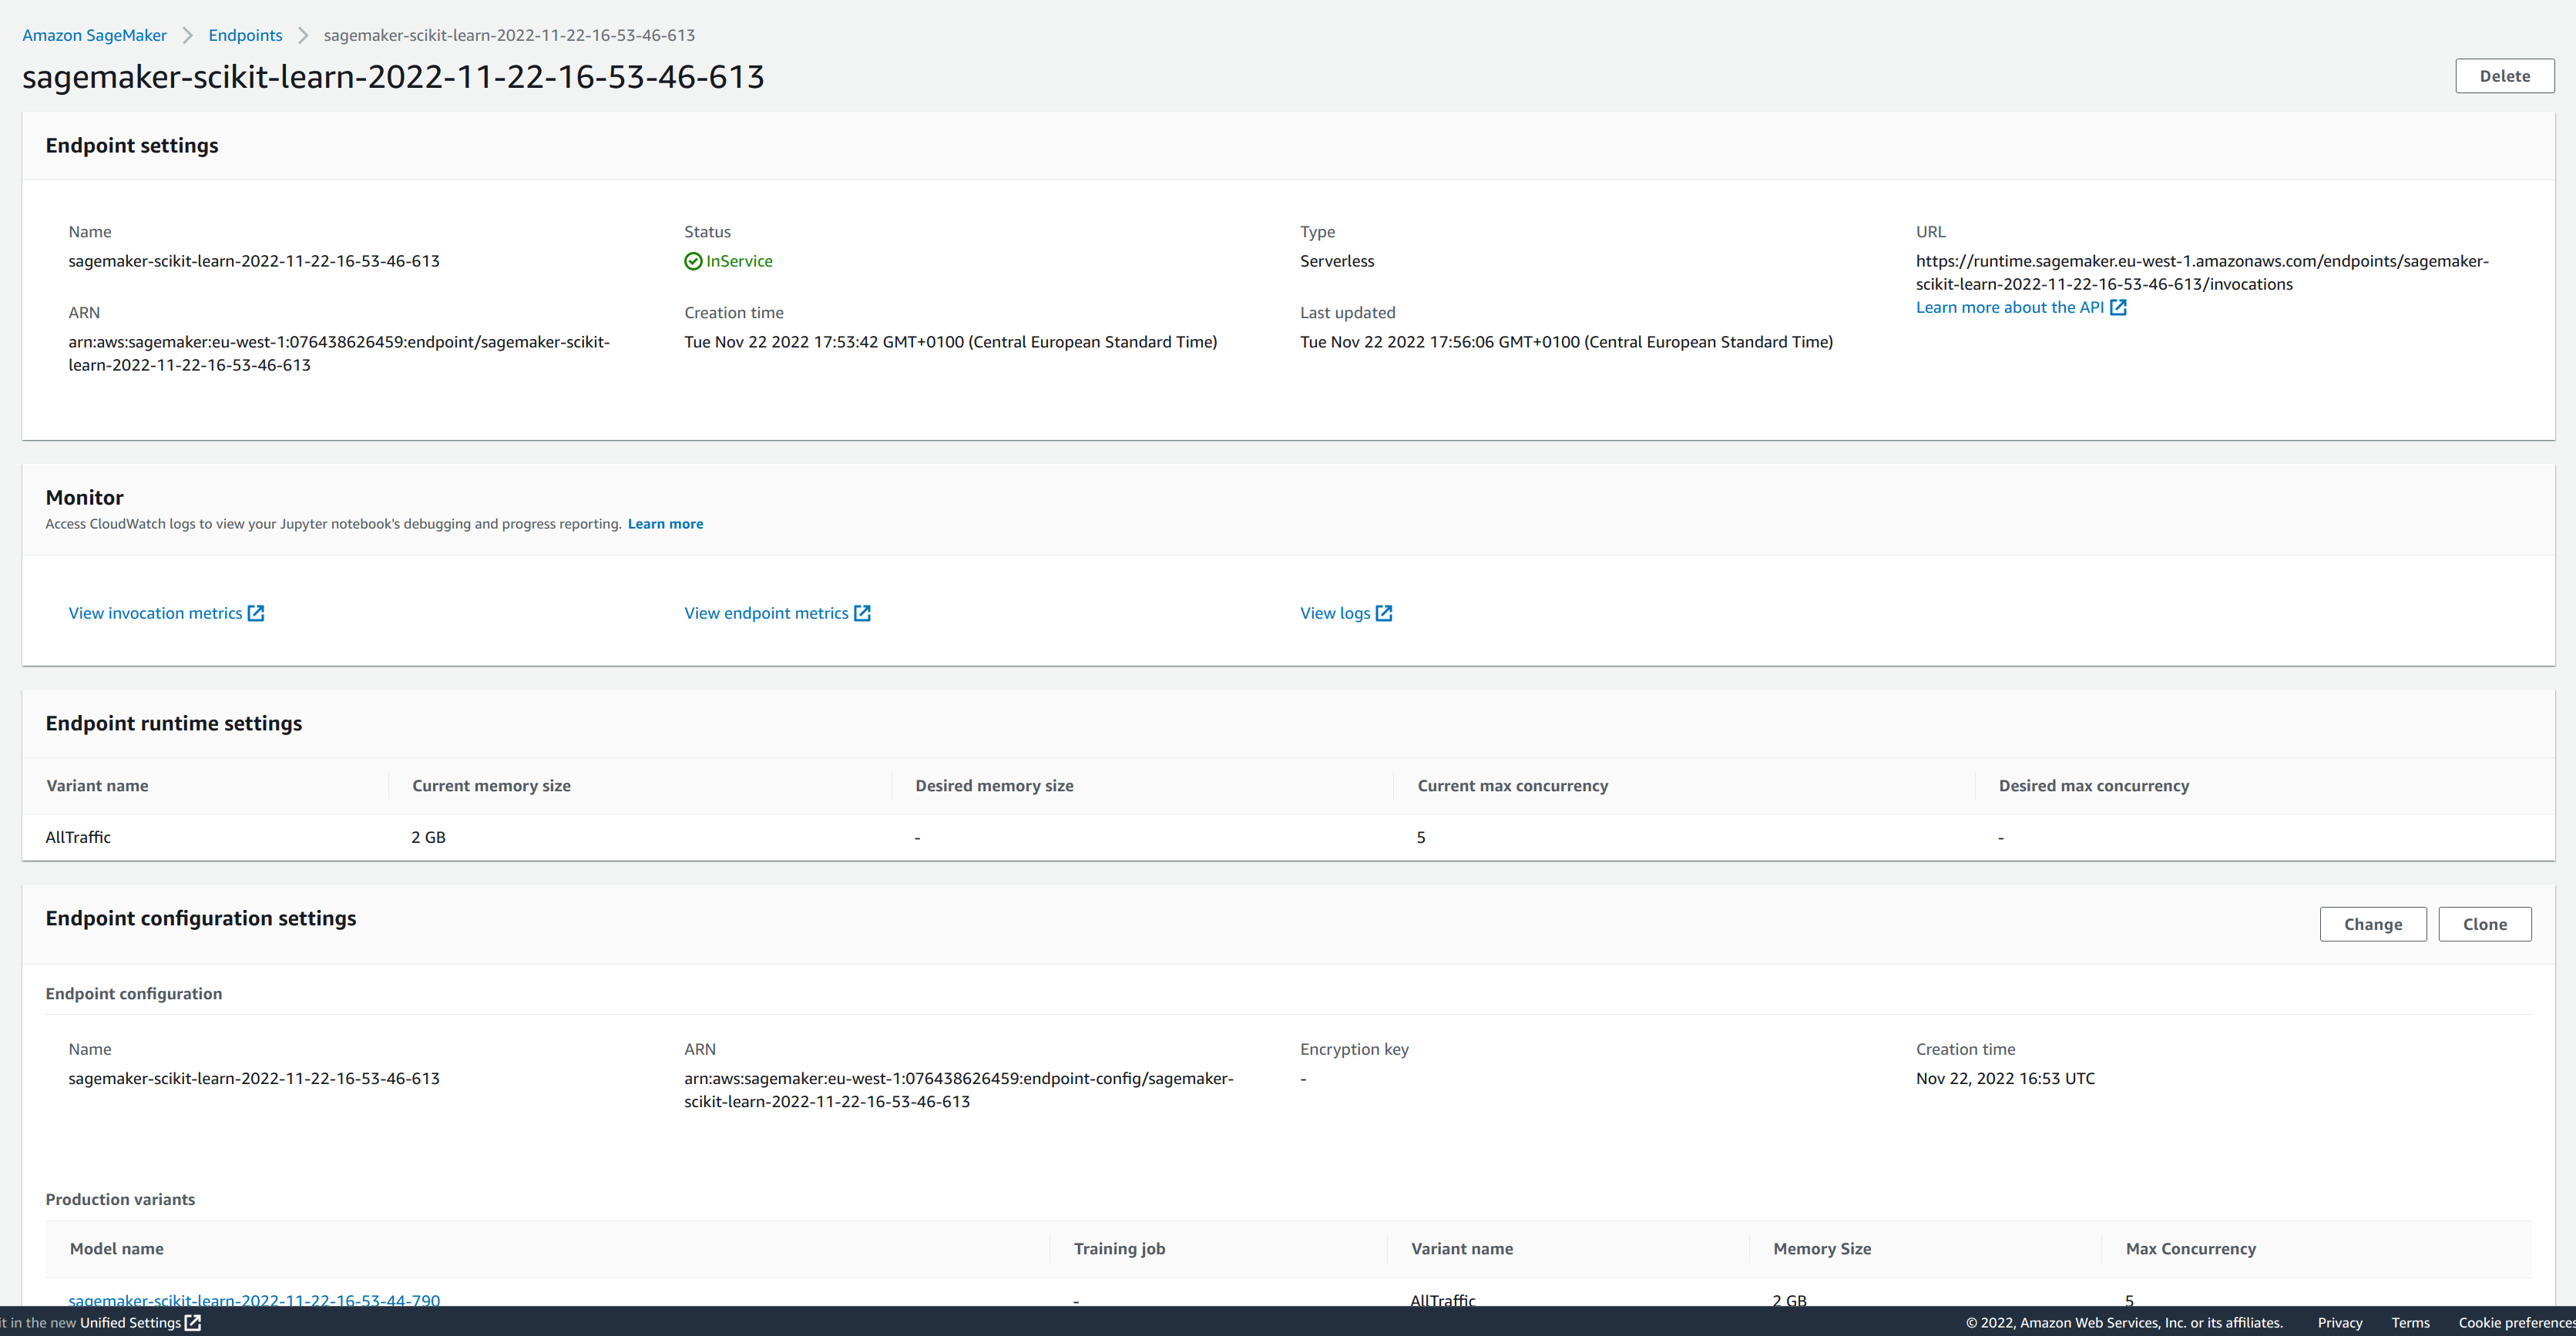

OK, now let's call our model with three first feature rows and compare local model prediction versus remote one:

In [52]:
import os
import io
import boto3
import json
import csv

runtime= boto3.client('runtime.sagemaker')

# First three feature rows
request_body_1 = {"Input": [[37, True, 27, False, 2, 0, 2, 0, 0, 0, 0, 0]]}
request_body_2 = {"Input": [[19, False, 29, True, 2, 3, 0, 0, 0, 0, 1, 0]]}
request_body_3 = {"Input": [[40, True, 28, False, 2, 0, 2, 0, 0, 0, 1, 0]]}
payload = json.dumps(request_body)

print(runtime.invoke_endpoint(EndpointName="sagemaker-scikit-learn-2022-11-22-16-53-46-613",
                                       ContentType='application/json',
                                       Body=json.dumps(request_body_1))['Body'].read().decode())
print(runtime.invoke_endpoint(EndpointName="sagemaker-scikit-learn-2022-11-22-16-53-46-613",
                                       ContentType='application/json',
                                       Body=json.dumps(request_body_2))['Body'].read().decode())
print(runtime.invoke_endpoint(EndpointName="sagemaker-scikit-learn-2022-11-22-16-53-46-613",
                                       ContentType='application/json',
                                       Body=json.dumps(request_body_3))['Body'].read().decode())

best_traditional_model.predict(features.head(3))

   age  training_before[Y/N]  body_fat[%]  smoking[Y/N]  alcohol_times_week  \
0   37                  True           27         False                   2   
1   19                 False           29          True                   2   
2   40                  True           28         False                   2   

   education  kids  gender_M  marital_status_married  \
0          0     2         0                       0   
1          3     0         0                       0   
2          0     2         0                       0   

   marital_status_separated  marital_status_single  marital_status_widowed  
0                         0                      0                       0  
1                         0                      1                       0  
2                         0                      1                       0  
{"Output":1}

{"Output":0}

{"Output":1}



array([ True, False,  True])

Wonderful! It all matches! Our model is successfully deployed!